In [1]:
"""A deep MNIST classifier using convolutional layers.
based on tutorials https://www.tensorflow.org/get_started/mnist/pros
and https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist
see Legal Notes at the end of the notebook
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

import random
import math

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet

import tensorflow as tf

SOURCE_URL = 'https://storage.googleapis.com/cloud-deeplearning/kaggle_mnist_data/'
DOWNLOAD_DATASETS=True
DATA_DIR = '../input/'
KAGGLE_TRAIN_CSV = 'train.csv'
KAGGLE_TEST_CSV = 'test.csv'
SUBMISSION_FILE = 'submission_mnist_cnn_augmented-3x.csv'

# should sum up to 42000, the total number of images in train.csv
TRAIN_SIZE = 38000
VALID_SIZE = 4000
TEST_SIZE = 0

random.seed(23032003)

In [2]:
def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

def compatible_convolutional_noise_shape(Y):
    noiseshape = tf.shape(Y)
    noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
    return noiseshape

In [3]:
def cnn():
    
# neural network structure for this sample:
#
# · · · · · · · · · ·      (input data, 1-deep)                    X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer +BN 6x6x1=>24 stride 1      W1 [5, 5, 1, 24]        B1 [24]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                              Y1 [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @     -- conv. layer +BN 5x5x6=>48 stride 2      W2 [5, 5, 6, 48]        B2 [48]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                Y2 [batch, 14, 14, 12]
#     @ @ @ @ @ @       -- conv. layer +BN 4x4x12=>64 stride 2     W3 [4, 4, 12, 64]       B3 [64]
#     ∶∶∶∶∶∶∶∶∶∶∶                                                  Y3 [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞      -- fully connected layer (relu+dropout+BN) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                                    Y4 [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)         W5 [200, 10]           B5 [10]
#        · · ·                                                     Y [batch, 10]

    # three convolutional layers with their channel counts, and a
    # fully connected layer (tha last layer has 10 softmax neurons)
    K = 24  # first convolutional layer output depth
    L = 48  # second convolutional layer output depth
    M = 64  # third convolutional layer
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

    # The model
    # batch norm scaling is not useful with relus
    # batch norm offsets are used instead of biases
    stride = 1  # output is 28x28
    Y1l = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
    Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional=True)
    Y1r = tf.nn.relu(Y1bn)
    Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))
    stride = 2  # output is 14x14
    Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
    Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
    Y2r = tf.nn.relu(Y2bn)
    Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))
    stride = 2  # output is 7x7
    Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
    Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
    Y3r = tf.nn.relu(Y3bn)
    Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4l = tf.matmul(YY, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
    Y4r = tf.nn.relu(Y4bn)
    Y4 = tf.nn.dropout(Y4r, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    return Y, Ylogits

In [4]:
def augment_images(images):

#     always = lambda aug: iaa.Sometimes(1.0, aug)

    # AFFINE (self, scale=1.0, translate_percent=None, translate_px=None,
    #                  rotate=0.0, shear=0.0, order=1, cval=0, mode="constant",
    #                  name=None, deterministic=False, random_state=None):

    augmented_images = np.empty((len(images),28,28,1))

    for index in range(len(images)):
        if index % 1000 == 0:
            print('. {0} images augmented'.format(index))
        seq = iaa.Sequential([
            iaa.Affine(rotate=random.uniform(15.0,20.0)*random.randint(-1,1)),
            iaa.Affine(translate_px=[random.randint(-2,2), random.randint(-2,2)]),
            iaa.Affine(shear=random.uniform(10.0,20.0)*random.randint(-1,1)),
            iaa.Affine(scale=random.uniform(0.9,1.1)),
            iaa.ContrastNormalization(alpha=2),
#             iaa.Sharpen(lightness=1.5),
        ])

        augmented_image = seq.augment_images([images[index]])[0]
        augmented_images[index] = np.expand_dims(augmented_image, axis=2)

    return augmented_images

In [5]:
def shuffle_same_order(a, b):
    """
    https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    """
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
def custom_kaggle_mnist():
    """
    downloads and parses mnist train dataset for kaggle digit recognizer
    parsing and one_hot copied https://www.kaggle.com/kakauandme/tensorflow-deep-nn
    """
    if DOWNLOAD_DATASETS:
        base.maybe_download(KAGGLE_TRAIN_CSV, DATA_DIR, SOURCE_URL + KAGGLE_TRAIN_CSV)

    # Import data from datasource, see https://www.kaggle.com/kakauandme/tensorflow-deep-nn
    # read training data from CSV file 
    data = pd.read_csv(DATA_DIR + KAGGLE_TRAIN_CSV)
    data = shuffle(data, random_state=42)
    
    images = data.iloc[:,1:].values
    images = images.reshape(-1,28,28)
    print(images.shape)

#     augmented_images = np.multiply(augment_images(images[:TRAIN_SIZE]), 1.0 / 255.0)

    augmented_images = augment_images(images[:TRAIN_SIZE])
    augmented_images_2 = augment_images(images[:TRAIN_SIZE])
    
    print('number of images in downloaded train dataset: {0[0]}'.format(images.shape))
    
    labels_flat = data.iloc[:,0].values
    labels_count = np.unique(labels_flat).shape[0]
    def dense_to_one_hot(labels_dense, num_classes):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        return labels_one_hot

    labels = dense_to_one_hot(labels_flat, labels_count)
    labels = labels.astype(np.uint8)
    # for augmented images
    labels = np.concatenate((labels, labels))
    
    # split data into training & validation
    mnist_train_images = images[:TRAIN_SIZE]
    mnist_train_labels = labels[:TRAIN_SIZE]
    
    # convert from [0:255] => [0.0:1.0]
#     mnist_train_images = np.multiply(mnist_train_images, 1.0 / 255.0)

    # augmentation
    mnist_train_images = np.concatenate((np.expand_dims(images[:TRAIN_SIZE], axis=3), augmented_images[:TRAIN_SIZE]))
    mnist_train_images = np.concatenate((mnist_train_images, augmented_images_2[:TRAIN_SIZE]))
#     mnist_train_images = np.expand_dims(images[:TRAIN_SIZE], axis=3)
    mnist_train_labels = np.concatenate((labels[:TRAIN_SIZE], labels[:TRAIN_SIZE]))
    mnist_train_labels = np.concatenate((mnist_train_labels, labels[:TRAIN_SIZE]))
    print('number of all train images: {0[0]}'.format(mnist_train_images.shape))

    mnist_valid_images = images[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
    mnist_valid_labels = labels[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
    mnist_valid_images = np.expand_dims(mnist_valid_images, axis=3)
    print('number of valid images: {0[0]}'.format(mnist_valid_images.shape))

    mnist_test_images = images[TRAIN_SIZE + VALID_SIZE:TRAIN_SIZE + VALID_SIZE + TEST_SIZE]
    mnist_test_labels = labels[TRAIN_SIZE + VALID_SIZE:TRAIN_SIZE + VALID_SIZE + TEST_SIZE]
    mnist_test_images = np.expand_dims(mnist_test_images, axis=3)
    print('number of test images: {0[0]}'.format(mnist_test_images.shape))
    
    # suffle train after augmentations
    mnist_train_images, mnist_train_labels = shuffle_same_order(mnist_train_images, mnist_train_labels)
    
    options = dict(dtype=np.float, reshape=False, seed=42)

    train = DataSet(mnist_train_images, mnist_train_labels, options)
    valid = DataSet(mnist_valid_images, mnist_valid_labels, options)
    test = DataSet(mnist_test_images, mnist_test_labels, options)

    return base.Datasets(train=train, validation=valid, test=test)

In [7]:
# Import data
mnist = custom_kaggle_mnist()

# strangely _num_examples is always 10000, even if fake_data were set to false explicitely
mnist.train._num_examples = mnist.train.images.shape[0]
mnist.validation._num_examples = mnist.validation.images.shape[0]
mnist.test._num_examples = mnist.test.images.shape[0]

(42000, 28, 28)
. 0 images augmented
. 1000 images augmented
. 2000 images augmented
. 3000 images augmented
. 4000 images augmented
. 5000 images augmented
. 6000 images augmented
. 7000 images augmented
. 8000 images augmented
. 9000 images augmented
. 10000 images augmented
. 11000 images augmented
. 12000 images augmented
. 13000 images augmented
. 14000 images augmented
. 15000 images augmented
. 16000 images augmented
. 17000 images augmented
. 18000 images augmented
. 19000 images augmented
. 20000 images augmented
. 21000 images augmented
. 22000 images augmented
. 23000 images augmented
. 24000 images augmented
. 25000 images augmented
. 26000 images augmented
. 27000 images augmented
. 28000 images augmented
. 29000 images augmented
. 30000 images augmented
. 31000 images augmented
. 32000 images augmented
. 33000 images augmented
. 34000 images augmented
. 35000 images augmented
. 36000 images augmented
. 37000 images augmented
. 0 images augmented
. 1000 images augmented
. 

In [8]:
def display_digit(image, label, num):
    """
    adapted from https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow
    """
    image = image.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

def visualize_input(img):
    """
    taken from https://github.com/udacity/aind2-cnn/blob/master/mnist-mlp/mnist_mlp.ipynb
    """
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

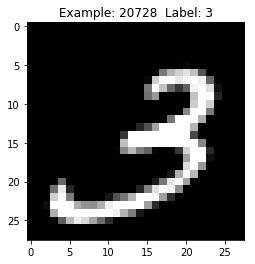

In [9]:
digit_index = random.randint(0, len(mnist.train.images))
display_digit(mnist.train.images[digit_index], mnist.train.labels[digit_index].argmax(), digit_index)
# visualize_input(mnist.train.images[digit_index])

In [10]:
if DOWNLOAD_DATASETS:
    kaggle_test_file = base.maybe_download(KAGGLE_TEST_CSV, DATA_DIR, SOURCE_URL + KAGGLE_TEST_CSV)

# kaggle test data
# test_kaggle = (pd.read_csv(kaggle_test_file).values).astype('float32')
test_kaggle = (pd.read_csv(DATA_DIR + KAGGLE_TEST_CSV).values).astype('uint8')
test_kaggle = test_kaggle.reshape(-1,28,28)
test_kaggle = np.expand_dims(test_kaggle, axis=3)


In [11]:
batch_size = 512

In [12]:
# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])
# variable learning rate
lr = tf.placeholder(tf.float32)
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)
# dropout probability
pkeep = tf.placeholder(tf.float32)
pkeep_conv = tf.placeholder(tf.float32)

# # Build the graph for the deep net
Y, Ylogits = cnn()

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*batch_size

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# cross_entropy = tf.reduce_mean(
#     tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=Y))
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

saver = tf.train.Saver()

In [13]:
# You can call this function in a loop to train the model, batch_size images at a time
def training_step(i, batch_X, batch_Y):

    # learning rate decay
    max_learning_rate = 0.01
    min_learning_rate = 0.0001
    decay_speed = 3000
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, tst: False, pkeep: 0.7, pkeep_conv: 0.7})

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Tensorflow version " + tf.__version__)
    tf.set_random_seed(42)
    for i in range(15000):
        batch_X, batch_Y = mnist.train.next_batch(batch_size)
        training_step(i, batch_X, batch_Y)
        if i % 200 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                X: batch_X, Y_: batch_Y, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
            validation_accuracy = accuracy.eval(feed_dict={
                X: mnist.validation.images, Y_: mnist.validation.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
            print('step %d, training accuracy: %g, validation accuracy %g' % (i, train_accuracy, validation_accuracy))

    print('validation accuracy %g' % accuracy.eval(feed_dict={
            X: mnist.validation.images, Y_: mnist.validation.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0}))
    validation_predictions = sess.run(tf.argmax(Y, 1), feed_dict={X: mnist.validation.images, Y_: mnist.validation.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
    validation_labels = sess.run(tf.argmax(mnist.validation.labels, 1))
    
    prediction_kaggle = tf.argmax(Y, 1)
    predictions = []
    pred_batch = 100
    for i in range(int(len(test_kaggle)/pred_batch)):
        feed_dict = {X : test_kaggle[i*pred_batch:(i+1)*pred_batch], tst: True, pkeep: 1.0, pkeep_conv: 1.0}
        predictions.extend(sess.run(prediction_kaggle, feed_dict))
        if i % 50 == 0:
            print('{} images predicted.'.format(i*pred_batch))
    print('{} images predicted.'.format(len(test_kaggle)))
    
# -> validation accuracy 0.991

Tensorflow version 1.2.0
step 0, training accuracy: 0.222656, validation accuracy 0.21
step 200, training accuracy: 0.951172, validation accuracy 0.9785
step 400, training accuracy: 0.978516, validation accuracy 0.98175
step 600, training accuracy: 0.978516, validation accuracy 0.985
step 800, training accuracy: 0.978516, validation accuracy 0.9835
step 1000, training accuracy: 0.984375, validation accuracy 0.98625
step 1200, training accuracy: 0.984375, validation accuracy 0.98675
step 1400, training accuracy: 0.986328, validation accuracy 0.98675
step 1600, training accuracy: 0.992188, validation accuracy 0.98725
step 1800, training accuracy: 0.992188, validation accuracy 0.989
step 2000, training accuracy: 0.990234, validation accuracy 0.98825
step 2200, training accuracy: 0.990234, validation accuracy 0.98875
step 2400, training accuracy: 1, validation accuracy 0.98875
step 2600, training accuracy: 0.986328, validation accuracy 0.98575
step 2800, training accuracy: 0.998047, valida

In [15]:
def show_wrong_validation(predictions, valid_labels):
  """
  from http://euler.stat.yale.edu/~tba3/stat665/lectures/lec17/notebook17.html
  """
#   predictions = sess.run(tf.argmax(Y, 1), feed_dict={X: mnist.validation.images, Y_: mnist.validation.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})

#   valid_labels = sess.run(tf.argmax(mnist.validation.labels, 1))

  wrong_valid = [im for im in zip(mnist.validation.images, predictions, valid_labels) if im[1] != im[2]]

  print('{0} out of {1} validation images were classified incorrectly'.format(len(wrong_valid), mnist.validation.images.shape[0]))

  plt.figure(figsize=(10, 10))
  for ind, val in enumerate(wrong_valid[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1.2)
    plt.subplot(10, 10, ind + 1)
    im = val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, -2, val[2], fontsize=14, color='blue')
    plt.text(8, -2, val[1], fontsize=14, color='red')
    plt.imshow(im, cmap=plt.get_cmap('gray'))
  plt.show()

36 out of 4000 validation images were classified incorrectly


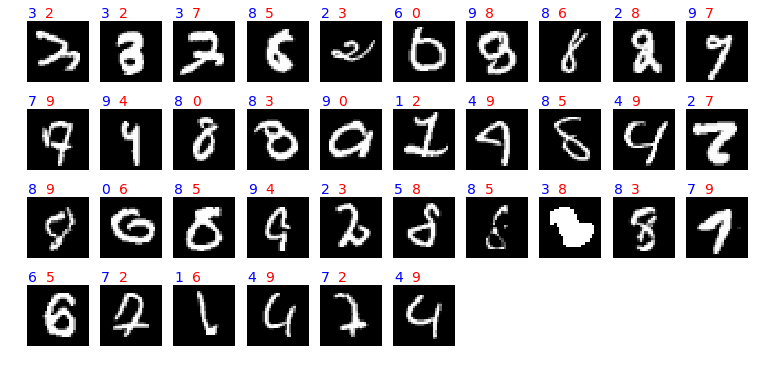

In [16]:
show_wrong_validation(validation_predictions, validation_labels)

In [17]:
with open(SUBMISSION_FILE, 'w') as submission:
  submission.write('ImageId,Label\n')
  for index, prediction in enumerate(predictions):
    submission.write('{0},{1}\n'.format(index + 1, prediction))
  print("prediction submission written to {0}".format(SUBMISSION_FILE))
# -> kaggle score of 0.99286

prediction submission written to submission_mnist_cnn_augmented-3x.csv


## The end

In [ ]:
# developing augmentation

# data = pd.read_csv(DATA_DIR + KAGGLE_TRAIN_CSV)
# from sklearn.utils import shuffle
# data = shuffle(data, random_state=42)
# images = data.iloc[:,1:].values    
# images = images.reshape(-1,28,28,1)
# print(images.shape)
# augmented_imgs = augment_images(images[:2])
# print(images[:2].shape)
# print(augmented_imgs.shape)
# print(len(augmented_imgs))
# images = np.concatenate((images[:2], augmented_imgs ))

In [ ]:
# train with checkpoint

# with tf.Session() as sess:
    
#     sess.run(tf.global_variables_initializer())
#     print("Tensorflow version " + tf.__version__)
#     tf.set_random_seed(42)
#     for i in range(2000):
#         batch_X, batch_Y = mnist.train.next_batch(50)
#         training_step(batch_X, batch_Y)
#         if i % 200 == 0:
#             train_accuracy = accuracy.eval(feed_dict={
#                 X: batch_X, Y_: batch_Y, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
#             print('step %d, training accuracy %g' % (i, train_accuracy))
#     saver.save(sess, './model/cnn.mnist.model.ckpt')


In [ ]:
# predict from checkpoint

# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
#     saver.restore(session, './model/cnn.mnist.model.ckpt')
    
#     print('validation accuracy %g' % accuracy.eval(feed_dict={
#         X: mnist.validation.images, Y_: mnist.validation.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0}))

In [ ]:
# predict from checkpoint

# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
#     saver.restore(session, './model/cnn.mnist.model.ckpt')

#     prediction_kaggle = tf.argmax(Y, 1)
#     predictions = []
#     pred_batch = 100
#     for i in range(int(len(test_kaggle)/pred_batch)):
#         feed_dict = {X : test_kaggle[i*pred_batch:(i+1)*pred_batch], tst: True, pkeep: 1.0, pkeep_conv: 1.0}
#         predictions.extend(sess.run(prediction_kaggle, feed_dict))
#         if i % 50 == 0:
#             print('{} images predicted.'.format(i*pred_batch))
#     print('{} images predicted.'.format(len(test_kaggle)))

In [ ]:
# Legal Notes:

# Copyright and License
# from https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_4.2_batchnorm_convolutional.py

# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================